## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM
import json
from tensorflow.keras.optimizers import RMSprop

# Download the dataset

In [2]:
!kaggle datasets download -d jainpooja/fake-news-detection

Dataset URL: https://www.kaggle.com/datasets/jainpooja/fake-news-detection
License(s): unknown
fake-news-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!kaggle datasets download -d ronikdedhia/next-word-prediction

Dataset URL: https://www.kaggle.com/datasets/ronikdedhia/next-word-prediction
License(s): unknown
next-word-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!kaggle datasets download -d asifmahmudcste/next-word-prediction-bangla

Dataset URL: https://www.kaggle.com/datasets/asifmahmudcste/next-word-prediction-bangla
License(s): unknown
next-word-prediction-bangla.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!kaggle datasets download -d zeyadsayedadbullah/synthetic-phone-call-conversation

Dataset URL: https://www.kaggle.com/datasets/zeyadsayedadbullah/synthetic-phone-call-conversation
License(s): MIT
synthetic-phone-call-conversation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip fake-news-detection.zip
!unzip next-word-prediction.zip
!unzip next-word-prediction-bangla.zip
!unzip synthetic-phone-call-conversation.zip

Archive:  fake-news-detection.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                
Archive:  next-word-prediction.zip
replace 1661-0.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 1661-0.txt              
Archive:  next-word-prediction-bangla.zip
replace 4gram_tokenized_dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 4gram_tokenized_dataset.txt  
replace 5gram_tokenized_dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 5gram_tokenized_dataset.txt  
replace bigram_tokenized_dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bigram_tokenized_dataset.txt  
replace original dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: original dataset.txt    
replace trigram_tokenized_dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: trigram_tokenized_dataset.txt  
repla

# Data Cleaning and preprocessing

In [7]:
import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/unigram_tokenized_dataset.txt
/content/original dataset.txt
/content/next-word-prediction.zip
/content/4gram_tokenized_dataset.txt
/content/bigram_tokenized_dataset.txt
/content/Fake.csv
/content/next-word-prediction-bangla.zip
/content/train.json
/content/synthetic-phone-call-conversation.zip
/content/fake-news-detection.zip
/content/True.csv
/content/1661-0.txt
/content/trigram_tokenized_dataset.txt
/content/5gram_tokenized_dataset.txt
/content/.config/.last_opt_in_prompt.yaml
/content/.config/default_configs.db
/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/gce
/content/.config/active_config
/content/.config/logs/2024.10.01/16.11.43.830597.log
/content/.config/logs/2024.10.01/16.12.19.078636.log
/content/.config/logs/2024.10.01/16.12.31.998949.log
/content/.config/logs/2024.10.01/16.12.18.079304.log
/content/.c

In [8]:
with open('/content/train.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Print the unique values in the 'tag' column
print(df['tag'].unique())

['phone call' 'meeting' 'face-to-face conversation' 'general chatting'
 'presentation' 'training']


In [9]:
df

,id,tag,title,original_language,conversation
0,190329_J07_03,phone call,伝言への折り返し電話打ち合わせ日程調整,ja,"[{'no': 1, 'ja_speaker': '土井さん', 'en_speaker':..."
1,190329_J06_11,meeting,株主総会に関する役員向け説明（２）,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
2,190329_J06_10,meeting,株主総会に関する役員向け説明（１）,ja,"[{'no': 1, 'ja_speaker': '友井さん', 'en_speaker':..."
3,190329_J06_09,face-to-face conversation,信託銀行から株主名簿を受領,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
4,190329_J06_08,face-to-face conversation,株主総会への臨場要請,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
...,...,...,...,...,...
665,190315_E001_05,presentation,Presentation: Company introduction,en,"[{'no': 1, 'en_speaker': 'Mr. Asano Yuki', 'ja..."
666,190315_E001_04,training,Training: training a new employee,en,"[{'no': 1, 'en_speaker': 'Mr. Ben Sherman', 'j..."
667,190315_E001_03,general chatting,General chatting: Company Christmas party,en,"[{'no': 1, 'en_speaker': 'Ms. Amy Lin', 'ja_sp..."
668,190315_E001_02,phone call,Phone call: requesting a lunch meeting.,en,"[{'no': 1, 'en_speaker': 'Mr. John Smith', 'ja..."


In [10]:
df_convs = pd.concat([pd.json_normalize(df['conversation'][i]) for i in range(len(df))],ignore_index=True)
train_en = df_convs["en_sentence"].values.tolist()
train_ja = df_convs["ja_sentence"].values.tolist()

In [11]:
df_convs

,no,ja_speaker,en_speaker,ja_sentence,en_sentence
0,1,土井さん,Doi-san,はい、K社システム開発部です。,Hi this is the systems development department ...
1,2,高市さん,Takaichi-san,H社の高市と申します。,My name is Takaichi from Company H.
2,3,高市さん,Takaichi-san,いつもお世話になっております。,Thank you as always.
3,4,土井さん,Doi-san,こちらこそ、お世話になっております。,Thank you as always as well.
4,5,高市さん,Takaichi-san,稲田さんはいらっしゃいますか？,Is Inada-san there?
...,...,...,...,...,...
19995,28,ボブ クックさん,Mr. Bob Cook,今日の5時までに書き上げます。,I'll finish it by 5 o'clock today.
19996,29,アル ジョンソンさん,Mr. Al Johnson,完璧だね。,Perfect.
19997,30,アル ジョンソンさん,Mr. Al Johnson,明日ゼネラルマネージャーにA社の件を話しておきますね。,I'll go talk to the general manager tomorrow t...
19998,31,アル ジョンソンさん,Mr. Al Johnson,彼がA社を気に入ってくれて、投資できる方向に決まることを願いましょう。,Hopefully he will like Company A and make the ...


In [12]:
train_en[:10]

['Hi this is the systems development department of Company K.',
 'My name is Takaichi from Company H.',
 'Thank you as always.',
 'Thank you as always as well.',
 'Is Inada-san there?',
 'It seems I got a call from him around 1 hour ago.',
 'Yes, let me switch you over.',
 'Please wait a moment.',
 'Inada-san, you have a call from Mr. Takaichi of Company H.',
 'Hello, this is Inada.']

In [13]:
text = ' '.join(train_en[0:10000])
print('length of the corpus is: :', len(text))

length of the corpus is: : 532978


# Tokenization

In [14]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [15]:
# get unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [16]:
unique_words[1000:1020]

array(['Shanghai', 'She', 'Shibata', 'Shibuya', 'Shiota', 'Shiraishi',
       'Shiroki', 'Shirota', 'Shizuo', 'Shodoshima', 'Shop', 'Should',
       'Shouldn', 'Shuji', 'Silence', 'Silicone', 'Similar', 'Since',
       'Sir', 'Six'], dtype='<U16')

In [17]:
# model input = prev_words
# model output = next_words

WORD_LENGTH = 5
next_words = []
prev_words = []
for j in range(len(words) - WORD_LENGTH):
    prev_words.append(words[j:j + WORD_LENGTH])
    next_words.append(words[j + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['Hi', 'this', 'is', 'the', 'systems']
development


In [18]:
# convert features into numpy arrays
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
# prepare word2id index
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1
word2id = unique_word_index

In [19]:
# prepare id2word index ==> for inference
id2word = {y:x for x,y in unique_word_index.items()}

# Create the model

In [20]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the model

In [21]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
769/769 ━━━━━━━━━━━━━━━━━━━━ 234s 302ms/step - accuracy: 0.0492 - loss: 6.5907 - val_accuracy: 0.1051 - val_loss: 5.8225
Epoch 2/2
769/769 ━━━━━━━━━━━━━━━━━━━━ 228s 297ms/step - accuracy: 0.1399 - loss: 5.5350 - val_accuracy: 0.1536 - val_loss: 5.4922


# Evaluate the model

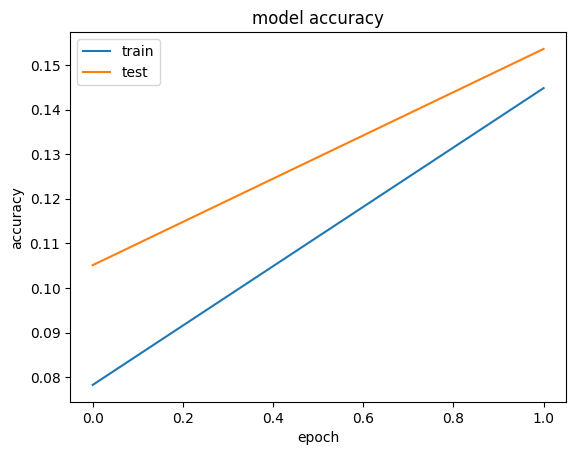

In [22]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

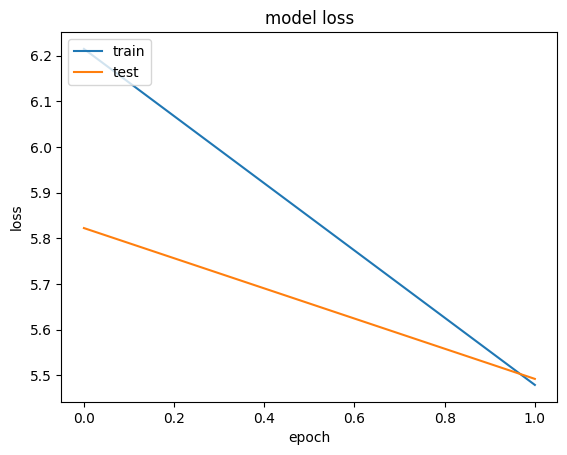

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Example usage

In [24]:
def prepare_input(text):
    words = tokenizer.tokenize(text)
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(words):
        x[0, t, word2id[word]] = 1.

    return x

In [25]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [26]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_word = id2word[next_index]
        text = text[1:] + next_word
        completion += next_word

        if len(original_text + completion) + 2 > len(original_text) and next_word == ' ':
            return completion

In [27]:
def predict_next_word(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [id2word[idx] for idx in next_indices]

In [28]:
# Model only accept input with 5 words
input="I look forward to working"
print(predict_next_word(input, 5))
'I look forward to working with'

['with', 'the', 'on', 'this', 'in']


'I look forward to working with'

In [29]:
input="look forward to working with"
print(predict_next_word(input, 5))
'I look forward to working with you'

['you', 'the', 'my', 'this', 'it']


'I look forward to working with you'

In [30]:
input="forward to working with you, "
print(predict_next_word(input, 5))

['Yes', 'today', 'Thank', 'tomorrow', 'I']


In [31]:
input="to working with you, I"
print(predict_next_word(input, 5))

['am', 'm', 'll', 'will', 'see']


In [32]:
input="working with you, I'm"
print(predict_next_word(input, 5))

['sure', 'sorry', 'going', 'not', 'very']


In [33]:
input="with you, I'm thinking"
print(predict_next_word(input, 5))

['of', 'it', 'I', 'that', 'to']


In [34]:
input="you, I'm thinking of"
print(predict_next_word(input, 5))

['the', 'this', 'it', 'course', 'that']


In [35]:
input="I'm thinking of the"
print(predict_next_word(input, 5))

['day', 'morning', 'new', 'way', 'office']


Final sentence: I look forward to working with you, I'm thinking of the company.